<a href="https://colab.research.google.com/github/jaumendes/cryptocharts/blob/main/doge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3761751491.py:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(df["Close"].iloc[i])
/tmp/ipython-input-3761751491.py:55: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  low = float(df["Low"].iloc[i])


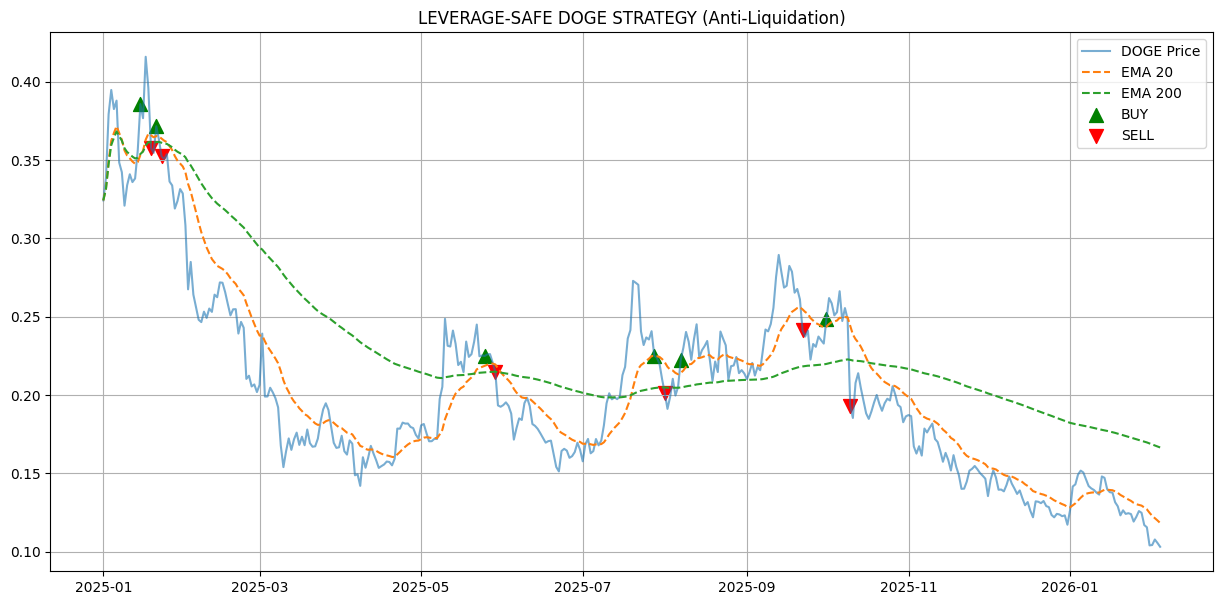

In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ======================
# CONFIGURATION
# ======================
ACCOUNT_SIZE = 10_000
RISK_PER_TRADE = 0.01
ATR_PERIOD = 14
EMA_FAST = 20
EMA_SLOW = 200

# ======================
# LOAD DATA
# ======================
df = yf.download(
    "DOGE-USD",
    start="2025-01-01",
    auto_adjust=True
)

# ======================
# INDICATORS
# ======================
df["EMA20"] = df["Close"].ewm(span=EMA_FAST).mean()
df["EMA200"] = df["Close"].ewm(span=EMA_SLOW).mean()

hl = df["High"] - df["Low"]
hc = (df["High"] - df["Close"].shift()).abs()
lc = (df["Low"] - df["Close"].shift()).abs()

df["ATR"] = pd.concat([hl, hc, lc], axis=1).max(axis=1).rolling(ATR_PERIOD).mean()

# ======================
# STATE
# ======================
position = 0.0
entry_price = 0.0
stop_price = 0.0
risk_amount = ACCOUNT_SIZE * RISK_PER_TRADE

buy_pins = []
sell_pins = []

# ======================
# BACKTEST LOOP
# ======================
for i in range(ATR_PERIOD, len(df)):
    price = float(df["Close"].iloc[i])
    atr = float(df["ATR"].iloc[i])
    ema20 = float(df["EMA20"].iloc[i])
    ema200 = float(df["EMA200"].iloc[i])
    low = float(df["Low"].iloc[i])

    if np.isnan(atr):
        continue

    # ========= ENTRY =========
    if position == 0:
        if price > ema200 and low <= ema20 and price > ema20:
            stop_price = price - (2 * atr)
            risk_per_unit = price - stop_price
            position = risk_amount / risk_per_unit
            entry_price = price
            buy_pins.append((df.index[i], price))

    # ========= EXIT =========
    else:
        # STOP LOSS
        if price <= stop_price:
            sell_pins.append((df.index[i], price))
            position = 0.0
            continue

        # MOVE STOP TO BREAKEVEN (1R)
        if price >= entry_price + (entry_price - stop_price):
            stop_price = entry_price

        # TRAIL STOP (2R+)
        if price >= entry_price + 2 * (entry_price - stop_price):
            stop_price = max(stop_price, price - atr)

        # EXIT ON TREND BREAK
        if price < ema200:
            sell_pins.append((df.index[i], price))
            position = 0.0

# ======================
# PLOT
# ======================
plt.figure(figsize=(15,7))

plt.plot(df.index, df["Close"], label="DOGE Price", alpha=0.6)
plt.plot(df.index, df["EMA20"], label="EMA 20", linestyle="--")
plt.plot(df.index, df["EMA200"], label="EMA 200", linestyle="--")

if buy_pins:
    bx, by = zip(*buy_pins)
    plt.scatter(bx, by, marker="^", color="green", s=100, label="BUY")

if sell_pins:
    sx, sy = zip(*sell_pins)
    plt.scatter(sx, sy, marker="v", color="red", s=100, label="SELL")

plt.title("LEVERAGE-SAFE DOGE STRATEGY (Anti-Liquidation)")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
import yfinance as yf
import pandas as pd
import numpy as np

# ======================
# CONFIG
# ======================
SYMBOL = "DOGE-USD"
ATR_PERIOD = 14
EMA_FAST = 20
EMA_SLOW = 200

# ======================
# LOAD DATA
# ======================
df = yf.download(
    SYMBOL,
    period="1y",
    interval="1d",
    auto_adjust=True
)

# ======================
# INDICATORS
# ======================
df["EMA20"] = df["Close"].ewm(span=EMA_FAST).mean()
df["EMA200"] = df["Close"].ewm(span=EMA_SLOW).mean()

hl = df["High"] - df["Low"]
hc = (df["High"] - df["Close"].shift()).abs()
lc = (df["Low"] - df["Close"].shift()).abs()

df["ATR"] = pd.concat([hl, hc, lc], axis=1).max(axis=1).rolling(ATR_PERIOD).mean()

# ======================
# LAST TWO CANDLES
# ======================
last = df.iloc[-1]
prev = df.iloc[-2]

price = float(last["Close"])
ema20 = float(last["EMA20"])
ema200 = float(last["EMA200"])
atr = float(last["ATR"])

prev_price = float(prev["Close"])
prev_ema20 = float(prev["EMA20"])

# ======================
# INFLECTION LOGIC
# ======================
action = "HOLD"
reason = ""

# --- BUY INFLECTION ---
if (
    price > ema200 and                     # uptrend
    prev_price < prev_ema20 and            # was below EMA20
    price > ema20                          # reclaimed EMA20
):
    action = "BUY"
    stop = price - 2 * atr
    reason = (
        "Bullish inflection detected: "
        "price reclaimed EMA20 in uptrend. "
        f"Suggested stop ≈ {stop:.4f}"
    )

# --- SELL INFLECTION ---
elif (
    price < ema20 and prev_price > prev_ema20
):
    action = "SELL / EXIT"
    reason = (
        "Bearish inflection detected: "
        "price lost EMA20 momentum."
    )

# --- HARD WARNING ---
elif price < ema200:
    action = "NO TRADE"
    reason = (
        "Market below EMA200. "
        "High liquidation risk with leverage."
    )

# ======================
# OUTPUT (REAL TIME MESSAGE)
# ======================
print("📊 REAL-TIME INFLECTION ENGINE")
print(f"Asset: {SYMBOL}")
print(f"Last Close: {price:.4f}")
print(f"EMA20 / EMA200: {ema20:.4f} / {ema200:.4f}")
print("-" * 40)
print(f"👉 ACTION: {action}")
print(f"🧠 REASON: {reason}")


[*********************100%***********************]  1 of 1 completed

📊 REAL-TIME INFLECTION ENGINE
Asset: DOGE-USD
Last Close: 0.1033
EMA20 / EMA200: 0.1184 / 0.1652
----------------------------------------
👉 ACTION: NO TRADE
🧠 REASON: Market below EMA200. High liquidation risk with leverage.



/tmp/ipython-input-3992026163.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(last["Close"])
/tmp/ipython-input-3992026163.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ema20 = float(last["EMA20"])
/tmp/ipython-input-3992026163.py:43: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ema200 = float(last["EMA200"])
/tmp/ipython-input-3992026163.py:44: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  atr = float(last["ATR"])
/tmp/ipython-input-3992026163.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3331976789.py:43: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(df["Close"].iloc[i])
/tmp/ipython-input-3331976789.py:44: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  prev_price = float(df["Close"].iloc[i - 1])
/tmp/ipython-input-3331976789.py:71: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(last["Close"])
/tmp/ipython-input-3331976789.py:72: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ema20 = float(last["EMA20"])
/tmp/ipython-input-3331976789.py:73: FutureWarning: Calling float 

📊 GALA CFD – REAL-TIME INFLECTION ENGINE
Preço atual: 0.00459
EMA20 / EMA200: 0.00569 / 0.01005
---------------------------------------------
👉 AÇÃO: NO TRADE
🧠 MOTIVO: Below EMA200 → regime desfavorável para alavancagem


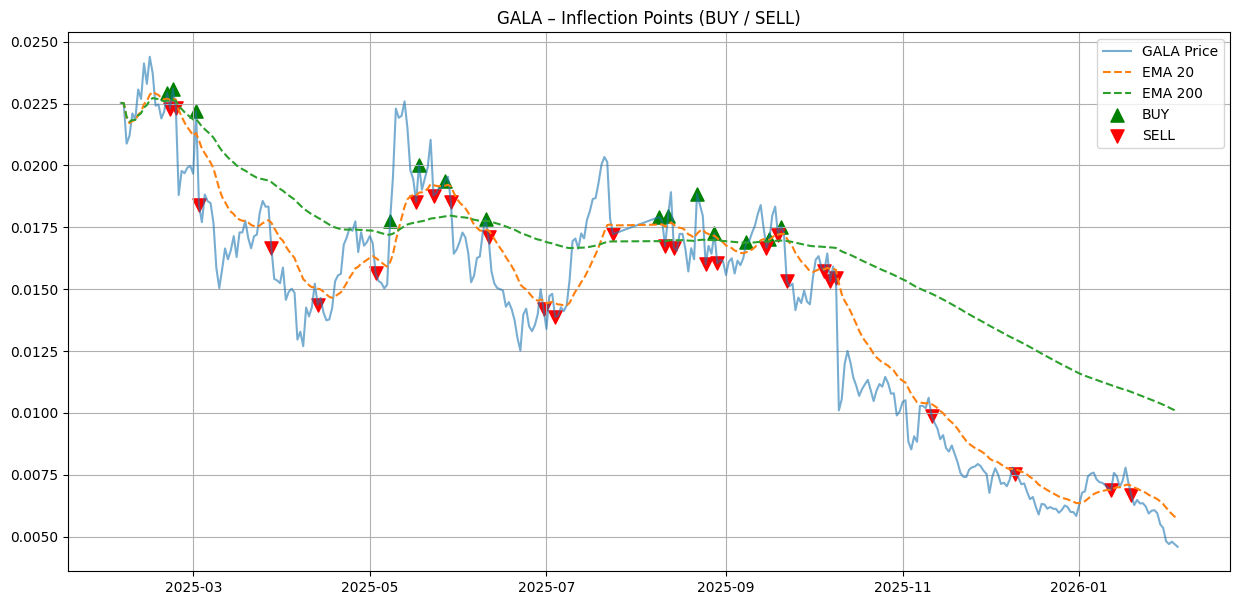

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ======================
# CONFIG
# ======================
SYMBOL = "GALA-USD"     # Proxy para GALA CFD
ATR_PERIOD = 14
EMA_FAST = 20
EMA_SLOW = 200

# ======================
# LOAD DATA
# ======================
df = yf.download(
    SYMBOL,
    period="1y",
    interval="1d",
    auto_adjust=True
)

# ======================
# INDICATORS
# ======================
df["EMA20"] = df["Close"].ewm(span=EMA_FAST).mean()
df["EMA200"] = df["Close"].ewm(span=EMA_SLOW).mean()

hl = df["High"] - df["Low"]
hc = (df["High"] - df["Close"].shift()).abs()
lc = (df["Low"] - df["Close"].shift()).abs()

df["ATR"] = pd.concat([hl, hc, lc], axis=1).max(axis=1).rolling(ATR_PERIOD).mean()

# ======================
# INFLECTION SCAN (HISTORICAL)
# ======================
buy_pins = []
sell_pins = []

for i in range(ATR_PERIOD + 1, len(df)):
    price = float(df["Close"].iloc[i])
    prev_price = float(df["Close"].iloc[i - 1])

    ema20 = float(df["EMA20"].iloc[i])
    prev_ema20 = float(df["EMA20"].iloc[i - 1])
    ema200 = float(df["EMA200"].iloc[i])

    # BUY inflection
    if (
        price > ema200 and
        prev_price < prev_ema20 and
        price > ema20
    ):
        buy_pins.append((df.index[i], price))

    # SELL inflection
    if (
        price < ema20 and
        prev_price > prev_ema20
    ):
        sell_pins.append((df.index[i], price))

# ======================
# REAL-TIME OUTPUT (LAST CANDLE)
# ======================
last = df.iloc[-1]
prev = df.iloc[-2]

price = float(last["Close"])
ema20 = float(last["EMA20"])
ema200 = float(last["EMA200"])
atr = float(last["ATR"])

prev_price = float(prev["Close"])
prev_ema20 = float(prev["EMA20"])

action = "HOLD"
reason = ""

if price < ema200:
    action = "NO TRADE"
    reason = "Below EMA200 → regime desfavorável para alavancagem"

elif prev_price < prev_ema20 and price > ema20:
    stop = price - 2 * atr
    action = "BUY"
    reason = (
        "Inflection bullish: preço recuperou EMA20 acima da EMA200. "
        f"Stop sugerido ≈ {stop:.5f}"
    )

elif prev_price > prev_ema20 and price < ema20:
    action = "SELL / EXIT"
    reason = "Inflection bearish: perda de momentum (EMA20)"

# ======================
# PRINT OUTPUT
# ======================
print("📊 GALA CFD – REAL-TIME INFLECTION ENGINE")
print(f"Preço atual: {price:.5f}")
print(f"EMA20 / EMA200: {ema20:.5f} / {ema200:.5f}")
print("-" * 45)
print(f"👉 AÇÃO: {action}")
print(f"🧠 MOTIVO: {reason}")

# ======================
# PLOT
# ======================
plt.figure(figsize=(15,7))

plt.plot(df.index, df["Close"], label="GALA Price", alpha=0.6)
plt.plot(df.index, df["EMA20"], label="EMA 20", linestyle="--")
plt.plot(df.index, df["EMA200"], label="EMA 200", linestyle="--")

if buy_pins:
    bx, by = zip(*buy_pins)
    plt.scatter(bx, by, marker="^", color="green", s=90, label="BUY")

if sell_pins:
    sx, sy = zip(*sell_pins)
    plt.scatter(sx, sy, marker="v", color="red", s=90, label="SELL")

plt.title("GALA – Inflection Points (BUY / SELL)")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import json
import os
from datetime import datetime

# =========================
# CONFIGURAÇÃO GERAL
# =========================
SYMBOL = "GALA-USD"          # Proxy para GALA CFD
INTERVAL = "4h"              # "1h" ou "4h"
LOOKBACK = "180d"            # histórico suficiente p/ EMA200
EMA_FAST = 20
EMA_SLOW = 200
ATR_PERIOD = 14

ACCOUNT_SIZE = 10_000        # ajuste para sua conta XTB
RISK_PER_TRADE = 0.01        # 1% por trade

STATE_FILE = "gala_state.json"

# =========================
# LOAD DATA
# =========================
df = yf.download(
    SYMBOL,
    period=LOOKBACK,
    interval=INTERVAL,
    auto_adjust=True
)

# =========================
# INDICADORES
# =========================
df["EMA20"] = df["Close"].ewm(span=EMA_FAST).mean()
df["EMA200"] = df["Close"].ewm(span=EMA_SLOW).mean()

hl = df["High"] - df["Low"]
hc = (df["High"] - df["Close"].shift()).abs()
lc = (df["Low"] - df["Close"].shift()).abs()

df["ATR"] = pd.concat([hl, hc, lc], axis=1).max(axis=1).rolling(ATR_PERIOD).mean()

# =========================
# LOAD STATE (MEMÓRIA)
# =========================
if os.path.exists(STATE_FILE):
    with open(STATE_FILE, "r") as f:
        state = json.load(f)
else:
    state = {
        "last_action": "NONE",
        "last_action_time": None
    }

# =========================
# LAST CANDLES
# =========================
last = df.iloc[-1]
prev = df.iloc[-2]

price = float(last["Close"])
ema20 = float(last["EMA20"])
ema200 = float(last["EMA200"])
atr = float(last["ATR"])

prev_price = float(prev["Close"])
prev_ema20 = float(prev["EMA20"])

# =========================
# DECISION ENGINE
# =========================
action = "HOLD"
reason = ""
stop = None
position_size = None

risk_amount = ACCOUNT_SIZE * RISK_PER_TRADE

# ---- REGIME FILTER ----
if price < ema200:
    action = "NO TRADE"
    reason = "Preço abaixo da EMA200 → regime perigoso para CFD"

# ---- BUY INFLECTION ----
elif (
    prev_price < prev_ema20 and
    price > ema20 and
    state["last_action"] != "BUY"
):
    stop = price - 2 * atr
    risk_per_unit = price - stop
    position_size = risk_amount / risk_per_unit

    action = "BUY"
    reason = (
        "Inflection bullish confirmada: "
        "reconquista da EMA20 em tendência de alta"
    )

# ---- SELL INFLECTION ----
elif (
    prev_price > prev_ema20 and
    price < ema20 and
    state["last_action"] == "BUY"
):
    action = "SELL / EXIT"
    reason = "Inflection bearish: perda de momentum (EMA20)"

# =========================
# SAVE STATE
# =========================
if action in ["BUY", "SELL / EXIT"]:
    state["last_action"] = action
    state["last_action_time"] = datetime.utcnow().isoformat()

    with open(STATE_FILE, "w") as f:
        json.dump(state, f, indent=2)

# =========================
# ALERT OUTPUT
# =========================
print("=" * 60)
print("📊 GALA CFD – INFLECTION ENGINE (REAL TIME)")
print(f"⏱ Timeframe: {INTERVAL}")
print(f"📈 Preço atual: {price:.5f}")
print(f"EMA20 / EMA200: {ema20:.5f} / {ema200:.5f}")
print("-" * 60)
print(f"👉 AÇÃO ATUAL: {action}")
print(f"🧠 MOTIVO: {reason}")

if action == "BUY":
    print(f"🛑 Stop sugerido: {stop:.5f}")
    print(f"📐 Tamanho da posição (nominal): {position_size:.2f}")

print("-" * 60)
print(f"📌 Última ação registrada: {state['last_action']}")
print(f"🕒 Horário da última ação: {state['last_action_time']}")
print("=" * 60)


[*********************100%***********************]  1 of 1 completed

📊 GALA CFD – INFLECTION ENGINE (REAL TIME)
⏱ Timeframe: 4h
📈 Preço atual: 0.00460
EMA20 / EMA200: 0.00480 / 0.00607
------------------------------------------------------------
👉 AÇÃO ATUAL: NO TRADE
🧠 MOTIVO: Preço abaixo da EMA200 → regime perigoso para CFD
------------------------------------------------------------
📌 Última ação registrada: NONE
🕒 Horário da última ação: None



/tmp/ipython-input-549802427.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(last["Close"])
/tmp/ipython-input-549802427.py:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ema20 = float(last["EMA20"])
/tmp/ipython-input-549802427.py:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ema200 = float(last["EMA200"])
/tmp/ipython-input-549802427.py:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  atr = float(last["ATR"])
/tmp/ipython-input-549802427.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3663356123.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(df["Close"].iloc[i])
/tmp/ipython-input-3663356123.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  prev_price = float(df["Close"].iloc[i - 1])


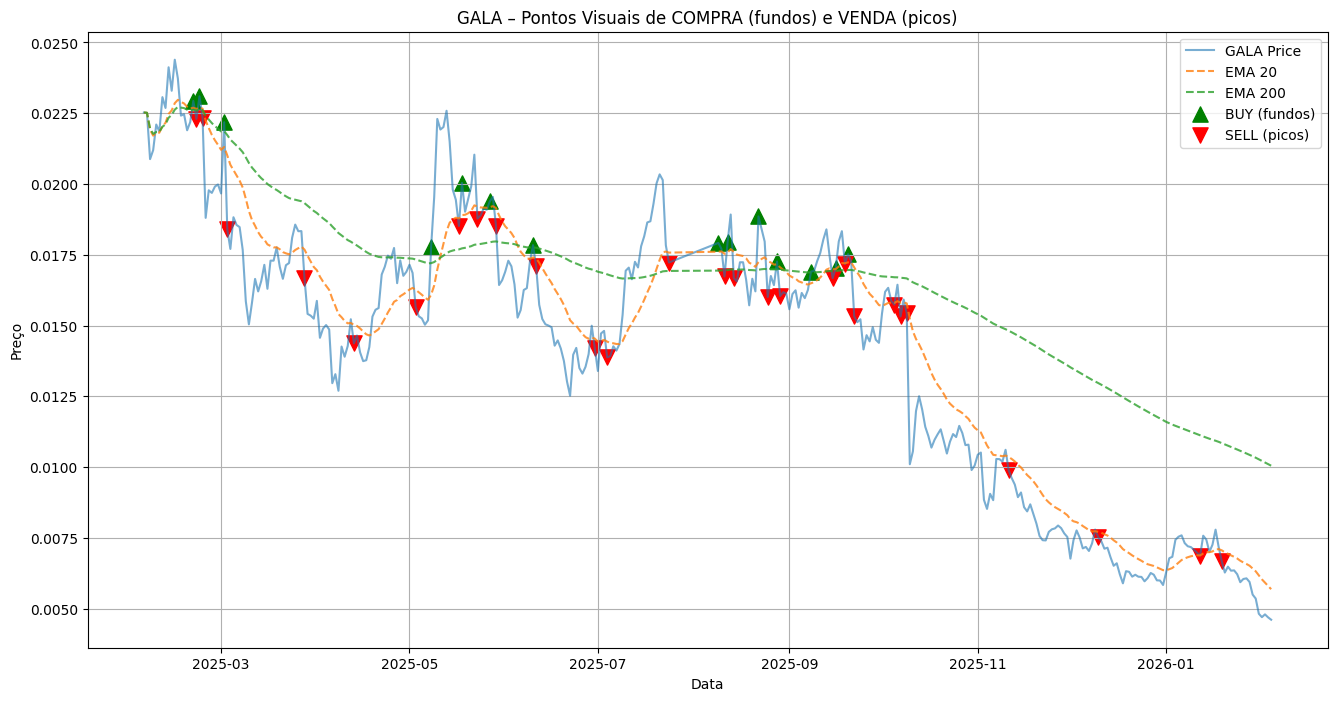

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ======================
# CONFIG
# ======================
SYMBOL = "GALA-USD"
INTERVAL = "1d"        # pode trocar para "4h" ou "1h"
LOOKBACK = "1y"

EMA_FAST = 20
EMA_SLOW = 200
ATR_PERIOD = 14

# ======================
# LOAD DATA
# ======================
df = yf.download(
    SYMBOL,
    period=LOOKBACK,
    interval=INTERVAL,
    auto_adjust=True
)

# ======================
# INDICATORS
# ======================
df["EMA20"] = df["Close"].ewm(span=EMA_FAST).mean()
df["EMA200"] = df["Close"].ewm(span=EMA_SLOW).mean()

hl = df["High"] - df["Low"]
hc = (df["High"] - df["Close"].shift()).abs()
lc = (df["Low"] - df["Close"].shift()).abs()
df["ATR"] = pd.concat([hl, hc, lc], axis=1).max(axis=1).rolling(ATR_PERIOD).mean()

# ======================
# FIND LOWS (BUY) & HIGHS (SELL)
# ======================
buy_pins = []
sell_pins = []

for i in range(ATR_PERIOD + 2, len(df)):
    price = float(df["Close"].iloc[i])
    ema20 = float(df["EMA20"].iloc[i])
    ema200 = float(df["EMA200"].iloc[i])

    prev_price = float(df["Close"].iloc[i - 1])
    prev_ema20 = float(df["EMA20"].iloc[i - 1])

    # 🟢 BUY = preço baixo + inflexão bullish
    if (
        price > ema200 and                    # tendência ok
        prev_price < prev_ema20 and           # estava fraco
        price > ema20                         # retomou força
    ):
        buy_pins.append((df.index[i], price))

    # 🔴 SELL = topo local + perda de momentum
    if (
        prev_price > prev_ema20 and
        price < ema20
    ):
        sell_pins.append((df.index[i], price))

# ======================
# PLOT
# ======================
plt.figure(figsize=(16,8))

plt.plot(df.index, df["Close"], label="GALA Price", alpha=0.6)
plt.plot(df.index, df["EMA20"], label="EMA 20", linestyle="--", alpha=0.8)
plt.plot(df.index, df["EMA200"], label="EMA 200", linestyle="--", alpha=0.8)

if buy_pins:
    bx, by = zip(*buy_pins)
    plt.scatter(bx, by, marker="^", color="green", s=120, label="BUY (fundos)")

if sell_pins:
    sx, sy = zip(*sell_pins)
    plt.scatter(sx, sy, marker="v", color="red", s=120, label="SELL (picos)")

plt.title("GALA – Pontos Visuais de COMPRA (fundos) e VENDA (picos)")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.legend()
plt.grid(True)
plt.show()
